In [74]:
import numpy as np
import pandas as pd
from scipy.stats import ortho_group
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
np.set_printoptions(suppress=True)


In [75]:
def hand_calc(x,y):
    xtx_1 = np.linalg.inv(x.T@x)
    beta1 = np.linalg.inv(x.T@x)@(x.T@y)
    y_hat = beta1.T@x.T
    RSS = np.sum((y-y_hat)**2)
    RSE = np.sum(np.sqrt(RSS))
    TSS = np.sum((y-np.mean(y))**2)
    R2 = ((TSS-RSS)/TSS)
    SE = np.sqrt(RSS/(x.shape[0] - x.shape[1]) * xtx_1)

    return xtx_1, beta1, y_hat, RSS, RSE, R2, SE

# Issues in OLS to consider and how they manifest

I initially wrote this to discuss the [assumptions of OLS](https://gregorygundersen.com/blog/2021/08/26/ols-estimator-sampling-distribution/#standard-ols-assumptions) (linearity, homoscedasticity, no OVB, no multicollinearity, normality of Y), however I took a long-winded turn into convincing myself for the Nth time that collinearity harms our precision and to understand why.


## Collinearity 

Below I create a regression of $Y = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \epsilon$ where my $x_{1}$ and $x_{2}$ are highly correlated. 

Due to the correlation in my covariates we deal with a few issues, practically speaking it will be difficult to understand if $\beta_{1}$ or $\beta_{2}$ is responsible for a unit change in $Y$, meaning we're not confident in our estimated values, this is reflected in larger standard error values. 

On the other hand, our estimates are unbiased! We are still explaining the true relationship between $Y$ and our $X's$, we're just unsure who is responsible for the effect.


### What does this mean for us?
- If you want to predict, we're fine.

- If you want to infer, we're in trouble. 

- We have true estimates, so we can predict well, but we can't truly determine if our estimators provide a causal impact or not.

### What can we do about collinearity? 
We don't have many options. We can use a number of tests to check if (multi)collinearity exists between our covariates. Typically a __VIF__ test works well, values greater than 10 to 15 might be a cause for concern. 

A few options in mind:
1. Drop if collinearity is very bad.
2. If collinearity is not very bad, if prediction is the name of the game, or if the collinear variable carries explanatory power for y then do not drop. 
3. Combine collinear variables into new variable.


Lets look at an example of two collinear variables:

In [76]:
np.random.seed(123)
rows = 100
x = ortho_group.rvs(dim=(rows))
x = np.append(np.full((rows,1), 1), x, axis=1)[:,:3]
x_6 = x.copy()
x_6[:,2] = x_6[:,1] + np.random.rand(rows)*0.15
y_6 = np.dot(x_6, [1,1,1]) + np.random.standard_normal(rows)*0.05
print('sanity check, x1 & x2 should have high correlation: {:.2f}'.format(np.corrcoef(x_6[:,1:3], rowvar=False)[0,1]))


sanity check, x1 & x2 should have high correlation: 0.92


First we run our regression with both covariates. Keep the standard error and beta coefficient of $x_{1}$ in mind.

*VIF is low because: https://stats.stackexchange.com/questions/445189/why-high-correlation-coefficient-doesnt-guarantee-high-vif#:~:text=As%20demonstrated%2C%20it's%20definitely%20possible,correlations%2C%20but%20have%20high%20VIF's.

My take: Have two covariates be mildly/strongly correlated might not be enough to pass the VIF "sniff test" (VIF >10 or 15). This is because an R^2 of a single variate regression will need to be extremely correlated to increase the VIF to 10 (think of an R^2 of 0.9). Having a multivariate regression for x1 on all other covariates, even with mild correlation will probably do the trick however.


In [77]:
p6_xtx_1, p6_beta1, p6_y_hat, p6_RSS, p6_RSE, p6_R2, p6_SE = hand_calc(x_6,y_6)
print('my coef:', p6_beta1)
print('my se:', np.diag(p6_SE))
print('my r2:', p6_R2)
print('VIF Scores: ',[variance_inflation_factor(x_6, i) for i in range(3)])
model = sm.OLS(y_6,x_6).fit()
model.summary()

my coef: [0.99264727 0.84977216 1.09630869]
my se: [0.00940184 0.11547962 0.10912604]
my r2: 0.9519165234217969
VIF Scores:  [4.372849128949262, 6.5932322352189585, 6.593232235218954]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     960.2
Date:                Fri, 17 Mar 2023   Prob (F-statistic):           1.19e-64
Time:                        14:49:19   Log-Likelihood:                 169.83
No. Observations:                 100   AIC:                            -333.7
Df Residuals:                      97   BIC:                            -325.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9926      0.009    105.580      0.000       0.974       1.011
x1             0.8498      0.115      7.359      0.000       0.621       1.079
x2             1.0963      0.109     10.046      0.000       0.880       1.313
==============================================================================
Omnibus:                        0.480   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.634
Skew:                           0.101   Prob(JB):                        0.728
Kurtosis:                       2.667   Cond. No.                         34.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let's drop $x_{2}$ (the collinear variable), now we see that $\hat{\beta_{1}}$ has a larger coefficient size and smaller standard error!

This is because we're now dealing with omitted variable bias instead of collinearity. This is because I've constructed my $x_1$ and $x_2$ to provide explanatory power for our $y$, even though the two covariates have a strong correlation.

We've essentially traded precision for bias, a losing deal for both a causal and prediction task!

In [78]:
r_x_6 = x_6[:,0:2]
r_p6_xtx_1, r_p6_beta1, r_p6_y_hat, r_p6_RSS, r_p6_RSE, r_p6_R2, r_p6_SE = hand_calc(r_x_6,y_6)
model = sm.OLS(y_6,r_x_6).fit()
print('my coef:', r_p6_beta1)
print('my se:', np.diag(r_p6_SE))
print('my r2:', r_p6_R2)
print('VIF Scores: ',[variance_inflation_factor(x_6, i) for i in range(3)])


print('''
After omitting x2, my beta_1 went from {:.4f} to {:.4f}, a difference of {:.4f}.

The standard error of my beta_1 also went from {:.4f} to {:.4f}, a difference of {:.4f}.
'''.format(p6_beta1[1], r_p6_beta1[1], p6_beta1[1]-r_p6_beta1[1],
    np.diag(p6_SE)[1], np.diag(r_p6_SE)[1],  np.diag(p6_SE)[1] -  np.diag(r_p6_SE)[1]))



my coef: [1.07559348 1.9183152 ]
my se: [0.0063914 0.063914 ]
my r2: 0.9018862348885971
VIF Scores:  [4.372849128949262, 6.5932322352189585, 6.593232235218954]

After omitting x2, my beta_1 went from 0.8498 to 1.9183, a difference of -1.0685.

The standard error of my beta_1 also went from 0.1155 to 0.0639, a difference of 0.0516.



__Why the coefficient changed__: Dropping a collinear variable $x_2$ will increase the coefficient of $x_1$ if $x_1$ was correlated with $x_2$ in the original model. This is because, in the original model, some of the effect of $x_1$ on $Y$ was being captured by $x_2$ as well. When $x_2$ is removed from the model, the effect of $x_1$ on $Y$ is no longer shared with $x_2$ and the coefficient of $x_1$ will increase to compensate for this.

Put another way, $Y$ is a linear combination of our betas, so $\beta{0}, \beta{1}, \&  \beta{2}$ would add together and all play a part to explain $Y$. Now that we dropped $\beta{2}$, we rely on $\beta{1}$ to pick up the explanatory power. Because these two covariates were correlated its very easy to do so! Here is our example:

In [79]:

print("(X'X) with x2:\n{}\n\nWithout x2:\n{}\n".format(
    (x_6.T@x_6).round(3),
    (r_x_6.T@r_x_6).round(3))
)

print("(X'X)^-1 with x2:\n{}\n\nWithout x2:\n{}\n".format(
    p6_xtx_1.round(10),
    r_p6_xtx_1.round(10))
)

print(''' Final (x'x)^(-1) * x'y:
WITH x2: {}
WITHOUT x2: {}
'''
.format(p6_beta1,
        r_p6_beta1)
)

(X'X) with x2:
[[100.      0.24    7.8  ]
 [  0.24    1.      0.993]
 [  7.8     0.993   1.728]]

Without x2:
[[100.     0.24]
 [  0.24   1.  ]]

(X'X)^-1 with x2:
[[ 0.04372849  0.43202476 -0.44571667]
 [ 0.43202476  6.59703872 -5.74188313]
 [-0.44571667 -5.74188313  5.8910836 ]]

Without x2:
[[ 0.01000577 -0.00240347]
 [-0.00240347  1.00057733]]

 Final (x'x)^(-1) * x'y:
WITH x2: [0.99264727 0.84977216 1.09630869]
WITHOUT x2: [1.07559348 1.9183152 ]



Why Standard Error Changed: Because of the strong correlation between $x_{1}$ and $x_{2}$, the covariance matrix will contain large values on the off diagonals, vastly altering how our precision matrix $(X'X)^{-1}$ is calculated, as the strong covariances will play a part on the diagonal values. Now that we've omitted $x_{2}$ entirely we no longer worry about the large off diagonals, lowering our new $(X'X)^{-1}$ .

An alternative way to see this is to look at the standard error equation for $\beta_{1}$ $$\text{SE}(\boldsymbol{\beta_{1}}) = \frac{\sigma}{\sqrt{1-R^{2}_{{x-x_{1}}}\cdot(N-1)\cdot(\sigma_{x_{1}})}}$$ here we see that the Standard Error is in part determined by $R^{2}_{x-x_{1}} which is the R-squared of regressing $x_{1}$ on all other x's... Considering our x's are correlated by design it makes mathematical sense our standard error were large when both covariates were included, as our $R^{2}_{x-x_{1}} was calculating by regression $x_{1}$ on $x_{2}$. Without $x_{2}$ any longer we're just regressing $x_{1}$ on some constant term (the mean)!


 For instance:

In [80]:
print(''' 
WITH x2: RSS avg(y-y_hat**2):{}
WITHOUT x2: RSS avg(y-y_hat**2): {}'''
      .format(p6_RSS.round(2), r_p6_RSS.round(2)))

print(''' 
WITH x2 value of x1 diagonal in (x'x)^-1 = {}
WITHOUT x2 value of x1 diagonal in (x'x)^-1 = {}
'''
    .format(np.diag(p6_xtx_1)[1],
            np.diag(r_p6_xtx_1)[1]))

print(''' Taken together we calculate SE of x1 for each by doing sqrt(RSS/(n-k-1) * (x'x)^-1).
WITH x2: sqrt({:.2f}\{} * {}) = {:.2f}
WITHOUT x2: sqrt({:.2f}\{} * {}) = {:.2f}
'''.format(p6_RSS, rows-2-1,np.diag(p6_xtx_1)[1], np.diag(p6_SE)[1],
        r_p6_RSS, rows-1-1,np.diag(r_p6_xtx_1)[1], np.diag(r_p6_SE)[1]))


 
WITH x2: RSS avg(y-y_hat**2):0.2
WITHOUT x2: RSS avg(y-y_hat**2): 0.4
 
WITH x2 value of x1 diagonal in (x'x)^-1 = 6.597038722430903
WITHOUT x2 value of x1 diagonal in (x'x)^-1 = 1.0005773324943064

 Taken together we calculate SE of x1 for each by doing sqrt(RSS/(n-k-1) * (x'x)^-1).
WITH x2: sqrt(0.20\97 * 6.597038722430903) = 0.12
WITHOUT x2: sqrt(0.40\98 * 1.0005773324943064) = 0.06



# SCRATCH WORK (USELESS)

In [81]:
def hand_calc(x,y):
    xtx_1 = np.linalg.inv(x.T@x)
    beta1 = np.linalg.inv(x.T@x)@(x.T@y)
    y_hat = beta1.T@x.T
    RSS = np.sum((y-y_hat)**2)
    RSE = np.sum(np.sqrt(RSS))
    TSS = np.sum((y-np.mean(y))**2)
    R2 = ((TSS-RSS)/TSS)
    SE = np.sqrt(RSS/(x.shape[0] - x.shape[1]) * xtx_1)
    return xtx_1, beta1, y_hat, RSS, RSE, R2, SE

1. Create Example Data

x: the x's are orthogonal to each other \
y: has some noise to it


Ok so very small correlation, that shouldn't much matter but could _slightly_ alter my correlated coefficients.


In [82]:
np.random.seed(123)
rows = 100
x = ortho_group.rvs(dim=(rows))
x = np.append(np.full((rows,1), 1), x, axis=1)[:,:3]
x1 = x[:, 1].reshape(rows,1)
x2 = x[:,2].reshape(rows,1)
y = np.dot(x, [1,1,1]) + np.random.standard_normal(rows)*0.05

print('sanity check, x1 & x2 should have no/low correlation: {:.5f}'.format(np.corrcoef(x,rowvar=False)[1,2]))


sanity check, x1 & x2 should have no/low correlation: 0.00023


In [83]:
xtx_1, beta1, y_hat, RSS, RSE, R2, SE = hand_calc(x,y)
print(SE)

model = sm.OLS(y,x).fit()

print('my se:', np.diag(SE))
print('my r2:', R2)
model.summary()

[[0.00499049        nan 0.00153078]
 [       nan 0.04990271        nan]
 [0.00153078        nan 0.04989052]]
my se: [0.00499049 0.04990271 0.04989052]
my r2: 0.8998119064332305


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     435.6
Date:                Fri, 17 Mar 2023   Prob (F-statistic):           3.46e-49
Time:                        14:49:19   Log-Likelihood:                 159.43
No. Observations:                 100   AIC:                            -312.9
Df Residuals:                      97   BIC:                            -305.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0004      0.005    200.465      0.000       0.991       1.010
x1             1.0570      0.050     21.180      0.000       0.958       1.156
x2             1.0253      0.050     20.552      0.000       0.926       1.124
==============================================================================
Omnibus:                        2.328   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                1.876
Skew:                           0.188   Prob(JB):                        0.391
Kurtosis:                       2.444   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

VIF is 1/(how well we can explain on covariates with the others).

Or 

$\frac{1}{R^{2}_{X_{j}|X_{-j}}}$

Where we calculate the R-squared of a regression of $X_{j}$ on all other covariates $X_{-j}$.

A value of 1 means no collinear relationships, where a value greater than 15ish is a cause for concern. 

Obviously I made these covariates to not vary with each other so the values are 1.


In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
print('VIF Scores: ',[variance_inflation_factor(x, i) for i in range(3)])

VIF Scores:  [1.0006659700128582, 1.0000000511142828, 1.0000000511142828]


2. What occurs when I take out an orthogonal, yet significant explanatory variable?

What we know:
1. x2 DOES explain our Y.
2. x1 & x2 are effectively not correlated in any way.


What should occur to x1 & why:
1. x1 beta coefficient should stay the same, the precision matrix $(x'x)^{-1}$ should be unaffected as $x1$ and $x2$ had little to no relation, therefore, when we take $x2$ out the variance/covariance of this matrix should stay very much the same.
2. x1 se should increase as our RSE has increased. x2 provided strong explanatory power we're now missing.
2. x1 se should decrease as our number of variables have decreased so n-k-1, where k went from 2 to 1, meaning our denominator is smaller.

In [85]:
r_x = x[:,0:2]
r_xtx_1, r_beta1, r_y_hat, r_RSS, r_RSE, r_R2, r_SE = hand_calc(r_x,y)
model = sm.OLS(y,r_x).fit()
print('my coef:', beta1)
print('my se:', np.diag(SE))
print('my r2:', R2)
model.summary()

my coef: [1.00042103 1.05696313 1.02533166]
my se: [0.00499049 0.04990271 0.04989052]
my r2: 0.8998119064332305


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     84.69
Date:                Fri, 17 Mar 2023   Prob (F-statistic):           6.51e-15
Time:                        14:49:19   Log-Likelihood:                 75.531
No. Observations:                 100   AIC:                            -147.1
Df Residuals:                      98   BIC:                            -141.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9995      0.011     86.999      0.000       0.977       1.022
x1             1.0572      0.115      9.202      0.000       0.829       1.285
==============================================================================
Omnibus:                        4.361   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                5.475
Skew:                           0.078   Prob(JB):                       0.0647
Kurtosis:                       4.136   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
print('''After omitting x2, my x1 went from {:.4f} to {:.4f}, a difference of {:.4f}.
'''.format(beta1[1], r_beta1[1], beta1[1]-r_beta1[1]))
                                                                          

print('''
The reason my x1 change after omitting x2 is due to the fact that I calculate my beta by (X'X)^(-1)X'Y, 
because x1 and x2 share a slight covariance with each other (-.0002), this changes my (X'X)^(-1) matrix slightly, as such:
''')

print("original (X'X)^-1:\n{}\n\nreduced form:\n{}\n".format(
    xtx_1.round(10),
    r_xtx_1.round(10))
)

print("As you can see, the x'y remains unchanged:")
print("(x'y):\n{}\n\nreduced form (x'y):\n{}".format(
    (x.T@y).round(4),
    (r_x.T@y).round(4))
)

After omitting x2, my x1 went from 1.0570 to 1.0572, a difference of -0.0002.


The reason my x1 change after omitting x2 is due to the fact that I calculate my beta by (X'X)^(-1)X'Y, 
because x1 and x2 share a slight covariance with each other (-.0002), this changes my (X'X)^(-1) matrix slightly, as such:

original (X'X)^-1:
[[ 0.01000666 -0.00240368  0.00094152]
 [-0.00240368  1.00057738 -0.00022616]
 [ 0.00094152 -0.00022616  1.00008859]]

reduced form:
[[ 0.01000577 -0.00240347]
 [-0.00240347  1.00057733]]

As you can see, the x'y remains unchanged:
(x'y):
[100.1995   1.2973   0.9312]

reduced form (x'y):
[100.1995   1.2973]


In [87]:
print(f'''
The standard error of x1 went from {np.diag(SE)[1].round(3)} to {np.diag(r_SE)[1].round(3)}.

The standard error changed, why?
Well standard error is computed by sqrt(RSS/(n-k-1) * (x'x)^-1).
Where RSS = variance of our error, the squared difference of the true y and our estimated y.
So sqrt(RSS\n-k-1) is the standard error of our variance.

Lets just call sqrt(RSS\n-k-1) as sigma...


sigma has changed for a few reasons:
1. SE grows: RSS = (y-y_hat)^2... Because we our y_hat is noisier without x2 we will expect RSS to become larger as the distance between any given y and y_hat has grown
2. SE grows:  k was 2 (x1, x2), now it is 1 (x1 only). This will reduce sigma as our numerator has become larger ever so slightly 


We then apply that to (x'x)^-1:
3. SE grows: because x1 and x2 had an slight correlation we will see an ever so slight change in our values here.''')


print(''' 
-- POINT 1 --
WITH x2: RSS avg(y-y_hat**2):{}
WITHOUT x2: RSS avg(y-y_hat**2): {}'''
      .format(RSS.round(2), r_RSS.round(2)))

print(''' 
-- POINT 2 --
WITH x2 RSS\(n-2-1) = {:.2f}\{} = {:.3f}
WITHOUT x2 RSS\(n-1-1) = {:.2f}\{} = {:.3f}
'''
    .format(RSS, rows-2-1, RSS/(rows-2-1),
            r_RSS, rows-1-1, r_RSS/(rows-1-1)))

print(''' 
-- POINT 3 --
WITH x2 value of x1 diagonal in (x'x)^-1 = {}
WITHOUT x2 value of x1 diagonal in (x'x)^-1 = {}
'''
    .format(np.diag(xtx_1)[1],
            np.diag(r_xtx_1)[1]))

print(''' Taken together we calculate SE of x1 for each by doing sqrt(RSS/(n-k-1) * (x'x)^-1).
WITH x2: sqrt({:.2f}\{} * {}) = {:.2f}
WITHOUT x2: sqrt({:.2f}\{} * {}) = {:.2f}
'''.format(RSS, rows-2-1, np.diag(xtx_1)[1], np.diag(SE)[1],
        r_RSS, rows-1-1, np.diag(r_xtx_1)[1], np.diag(r_SE)[1]))





The standard error of x1 went from 0.05 to 0.115.

The standard error changed, why?
Well standard error is computed by sqrt(RSS/(n-k-1) * (x'x)^-1).
Where RSS = variance of our error, the squared difference of the true y and our estimated y.
So sqrt(RSS
-k-1) is the standard error of our variance.

Lets just call sqrt(RSS
-k-1) as sigma...


sigma has changed for a few reasons:
1. SE grows: RSS = (y-y_hat)^2... Because we our y_hat is noisier without x2 we will expect RSS to become larger as the distance between any given y and y_hat has grown
2. SE grows:  k was 2 (x1, x2), now it is 1 (x1 only). This will reduce sigma as our numerator has become larger ever so slightly 


We then apply that to (x'x)^-1:
3. SE grows: because x1 and x2 had an slight correlation we will see an ever so slight change in our values here.
 
-- POINT 1 --
WITH x2: RSS avg(y-y_hat**2):0.24
WITHOUT x2: RSS avg(y-y_hat**2): 1.29
 
-- POINT 2 --
WITH x2 RSS\(n-2-1) = 0.24\97 = 0.002
WITHOUT x2 RSS\(n-1-1) = 1.2

$$SE(\hat{\beta_j}) = \sqrt{\frac{\hat{\sigma}^2}{\sum_{i=1}^{n}(x_{ij} - \bar{x_j})^2(1-R_j^2)}}$$

$$\sqrt{\hat{\sigma}^{2}(X'X)^{-1}}$$


In [88]:
x_minus_xbar = np.var(x_6[:,1])*rows
r2 = sm.OLS(x_6[:,1],x_6[:,[0,2]]).fit().rsquared


xtx_1, beta1, y_hat, RSS, RSE, R2, SE = hand_calc(x_6[:,[0,2]], x_6[:,1])

xtx = x_6[:,[0,2]].T@x_6[:,[0,2]]

TSS = np.sum((x_6[:,1]-np.mean(x_6[:,1]))**2)
RSS = np.sum((x_6[:,1]-y_hat)**2)
R2 = ((TSS-RSS)/TSS)

In [89]:
se_b1 = np.sqrt(p6_RSS/((TSS)*(1-((TSS-RSS)/TSS))*(rows-1)))
se_b1

0.11430720562798564

In [90]:
r_p6_SE

array([[0.0063914,       nan],
       [      nan, 0.063914 ]])

In [91]:
x = np.random.rand(100)

The variance of x is 1890.54


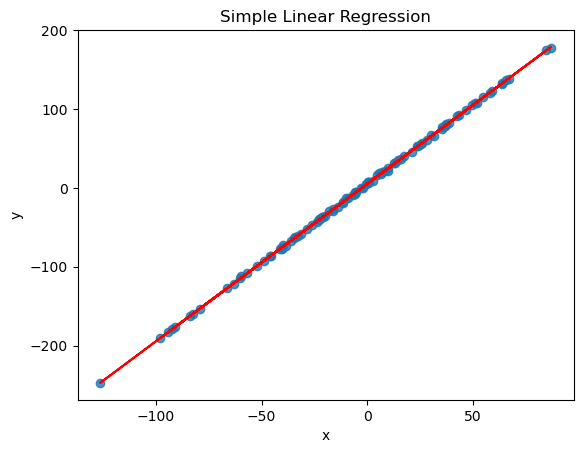

In [92]:
# Define the parameters for the regression equation
beta_0 = 5    # intercept
beta_1 = 2    # slope
n = 100       # sample size

# Generate the explanatory variable x with varying variance
variance = 2000
x = np.random.normal(loc=0, scale=np.sqrt(variance), size=n)

# Calculate the variance of x
x_var = np.var(x)

# Generate the response variable y using the regression equation
y = beta_0 + beta_1 * x + np.random.normal(loc=0, scale=1, size=n)

# Fit the regression model using numpy's polyfit function
slope, intercept = np.polyfit(x, y, 1)

# Plot the data and the fitted regression line
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.8)
ax.plot(x, slope * x + intercept, color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Simple Linear Regression')

# Print the variance of x
print(f"The variance of x is {x_var:.2f}")

plt.show()